In [16]:
import os
import h5py
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, random_split,Subset
import torch
import torch.nn as nn
import loralib as lora
import torch.nn.functional as F
from torchmetrics import JaccardIndex
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.typing import WITH_TORCH_CLUSTER
from torch_geometric.data import Data

from pyg_pointnet2 import PyGPointNet2NoColorLoRa
from pc_dataset import H5PCDataset


if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")

In [17]:
torch.cuda.empty_cache()

In [18]:
# take out colors
class SelectLast3Features:
    def __call__(self, data):
        # If data.x is defined, select only its last 3 features.
        if data.x is not None:
            data.x = data.x[:, -3:]
        return data

# transform and pre_transform
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])

pre_transform =  T.Compose([
    #T.NormalizeScale(),
    SelectLast3Features()
    ])

full_dataset = H5PCDataset(file_path='../docs/sim_pc_dataset_moved.h5', pre_transform=pre_transform)

# Define split sizes (e.g., 80% training and 20% validation)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Randomly split the dataset
train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

In [19]:
#Wrap train_subset in AugmentedSubset
class AugmentedSubset(Subset):
    def __init__(self, subset, transform):
        super().__init__(subset.dataset, subset.indices)
        self.transform = transform

    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        return self.transform(data)

train_dataset = AugmentedSubset(train_subset, transform)
test_dataset = test_subset 

In [20]:
print(train_dataset[0])
print(train_dataset.dataset.num_classes)
print(test_dataset[0])
print(test_dataset.dataset.num_classes)

Data(x=[4096, 3], y=[4096], pos=[4096, 3])
13
Data(x=[4096, 3], y=[4096], pos=[4096, 3])
13


In [21]:
batch_size=64
num_workers=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=True)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PyGPointNet2NoColorLoRa(num_classes=13).to(device)

In [23]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PyGPointNet2NoColorLoRa(num_classes=13).to(device)
model.load_state_dict(torch.load("checkpoints/pointnet2_s3dis_transform_seg_x3_45_checkpoint.pth", map_location=device), strict=False)  # Load pretrained weights

# Freeze all parameters except LoRA
for param in model.parameters():
    param.requires_grad = False

# Unfreeze LoRA parameters
for name, param in model.named_parameters():
    if "lora_" in name:  # LoRA parameters have "lora_A" or "lora_B" in their names
        param.requires_grad = True

In [24]:
model.eval()

PyGPointNet2NoColorLoRa(
  (sa1_module): SAModule(
    (conv): PointNetConv(local_nn=Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=128, bias=True)
    ), global_nn=None)
  )
  (sa2_module): SAModule(
    (conv): PointNetConv(local_nn=Sequential(
      (0): Linear(in_features=131, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=256, bias=True)
    ), global_nn=None)
  )
  (sa3_module): GlobalSAModule(
    (nn): Sequential(
      (0): Linear(in_features=259, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=1024, bias=True)
    )
  )
  (fp3_module): FPModule(
    (nn)

In [25]:
# Verify trainable parameters
trainable_params = [name for name, p in model.named_parameters() if p.requires_grad]
print("Trainable parameters:", trainable_params)

# After freezing the base model and enabling LoRA:
optimizer = torch.optim.Adam(
    [p for p in model.parameters() if p.requires_grad],  # Manual LoRA params
    lr=1e-3,
    weight_decay=0.01
)

Trainable parameters: ['sa1_module.conv.local_nn.0.lora_A', 'sa1_module.conv.local_nn.0.lora_B', 'sa1_module.conv.local_nn.2.lora_A', 'sa1_module.conv.local_nn.2.lora_B', 'sa1_module.conv.local_nn.4.lora_A', 'sa1_module.conv.local_nn.4.lora_B', 'sa2_module.conv.local_nn.0.lora_A', 'sa2_module.conv.local_nn.0.lora_B', 'sa2_module.conv.local_nn.2.lora_A', 'sa2_module.conv.local_nn.2.lora_B', 'sa2_module.conv.local_nn.4.lora_A', 'sa2_module.conv.local_nn.4.lora_B', 'sa3_module.nn.0.lora_A', 'sa3_module.nn.0.lora_B', 'sa3_module.nn.2.lora_A', 'sa3_module.nn.2.lora_B', 'sa3_module.nn.4.lora_A', 'sa3_module.nn.4.lora_B', 'fp3_module.nn.0.lora_A', 'fp3_module.nn.0.lora_B', 'fp3_module.nn.2.lora_A', 'fp3_module.nn.2.lora_B', 'fp2_module.nn.0.lora_A', 'fp2_module.nn.0.lora_B', 'fp2_module.nn.2.lora_A', 'fp2_module.nn.2.lora_B', 'fp1_module.nn.0.lora_A', 'fp1_module.nn.0.lora_B', 'fp1_module.nn.2.lora_A', 'fp1_module.nn.2.lora_B', 'fp1_module.nn.4.lora_A', 'fp1_module.nn.4.lora_B', 'mlp.0.lora_A

In [26]:
"""
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    total_loss = correct_nodes = total_nodes = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out.view(-1, 13), data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()
        total_nodes += data.num_nodes

        if (i + 1) % 10 == 0:
            print(f'[{i+1}/{len(train_loader)}] Loss: {total_loss / 10:.4f} '
                  f'Train Acc: {correct_nodes / total_nodes:.4f}')
            total_loss = correct_nodes = total_nodes = 0
    # If there are remaining batches that were not printed (i.e., i+1 not divisible by 10)
    if total_nodes > 0:
        num_remaining = (i + 1) % 10  # Number of batches in the leftover segment
        print(f'[{i+1}/{len(train_loader)}] Loss: {total_loss / num_remaining:.4f} '
              f'Train Acc: {correct_nodes / total_nodes:.4f}')
"""


"\ncriterion = torch.nn.CrossEntropyLoss()\n\ndef train():\n    model.train()\n\n    total_loss = correct_nodes = total_nodes = 0\n    for i, data in enumerate(train_loader):\n        data = data.to(device)\n        optimizer.zero_grad()\n        out = model(data)\n        loss = criterion(out.view(-1, 13), data.y.view(-1))\n        loss.backward()\n        optimizer.step()\n        total_loss += loss.item()\n        correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()\n        total_nodes += data.num_nodes\n\n        if (i + 1) % 10 == 0:\n            print(f'[{i+1}/{len(train_loader)}] Loss: {total_loss / 10:.4f} '\n                  f'Train Acc: {correct_nodes / total_nodes:.4f}')\n            total_loss = correct_nodes = total_nodes = 0\n    # If there are remaining batches that were not printed (i.e., i+1 not divisible by 10)\n    if total_nodes > 0:\n        num_remaining = (i + 1) % 10  # Number of batches in the leftover segment\n        print(f'[{i+1}/{len(train_loader)}

In [27]:
def train_one_epoch():
    model.train()
    running_loss = correct = total = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct      += out.argmax(1).eq(data.y).sum().item()
        total        += data.num_nodes

    # Average loss & accuracy for this epoch
    epoch_loss = running_loss / len(train_loader) 
    epoch_acc  = correct / total

    return epoch_loss, epoch_acc

In [28]:

@torch.no_grad()
def test(loader):
    model.eval()
    jaccard = JaccardIndex(num_classes=loader.dataset.dataset.num_classes, task="multiclass").to(device)
    
    for data in loader:
        data = data.to(device)
        outs = model(data)
        preds = outs.argmax(dim=-1)
        jaccard.update(preds, data.y)
    
    return jaccard.compute().item()


In [29]:
# Record history metrics
loss_history   = []
acc_history    = []
iou_history    = []
time_history   = []

In [30]:
for epoch in range(1, 51):
    # Track epoch start time
    start_time = time.perf_counter()
    #train()

    loss, acc = train_one_epoch()
    loss_history.append(loss)
    acc_history.append(acc)

    iou = test(test_loader)
    iou_history.append(iou)

    # Calculate epoch duration
    epoch_time = time.perf_counter() - start_time
    time_history.append(epoch_time)
    
    # Print results with time
    print(f"Epoch {epoch:02d} | "
          f"Loss: {loss:.4f} | "
          f"Acc: {acc:.4f} | "
          f"IoU: {iou:.4f} | "
          f"Time: {epoch_time:.2f}s")



Epoch 01 | Loss: 2.5861 | Acc: 0.0293 | IoU: 0.0041 | Time: 15.00s
Epoch 02 | Loss: 2.5669 | Acc: 0.0388 | IoU: 0.0041 | Time: 13.20s
Epoch 03 | Loss: 2.5410 | Acc: 0.0897 | IoU: 0.0116 | Time: 13.58s
Epoch 04 | Loss: 2.4682 | Acc: 0.2429 | IoU: 0.0367 | Time: 14.37s
Epoch 05 | Loss: 2.2908 | Acc: 0.3574 | IoU: 0.0367 | Time: 13.46s
Epoch 06 | Loss: 1.8762 | Acc: 0.3874 | IoU: 0.0367 | Time: 17.90s
Epoch 07 | Loss: 1.6780 | Acc: 0.3779 | IoU: 0.0367 | Time: 36.78s
Epoch 08 | Loss: 1.6608 | Acc: 0.3515 | IoU: 0.0367 | Time: 15.32s
Epoch 09 | Loss: 1.6406 | Acc: 0.3582 | IoU: 0.0367 | Time: 8.87s
Epoch 10 | Loss: 1.6356 | Acc: 0.3800 | IoU: 0.0367 | Time: 12.48s
Epoch 11 | Loss: 1.6434 | Acc: 0.3878 | IoU: 0.0367 | Time: 9.61s
Epoch 12 | Loss: 1.6465 | Acc: 0.3870 | IoU: 0.0367 | Time: 9.58s
Epoch 13 | Loss: 1.6087 | Acc: 0.3823 | IoU: 0.0367 | Time: 21.89s
Epoch 14 | Loss: 1.5804 | Acc: 0.3687 | IoU: 0.0367 | Time: 14.37s
Epoch 15 | Loss: 1.5887 | Acc: 0.3554 | IoU: 0.0367 | Time: 13.25

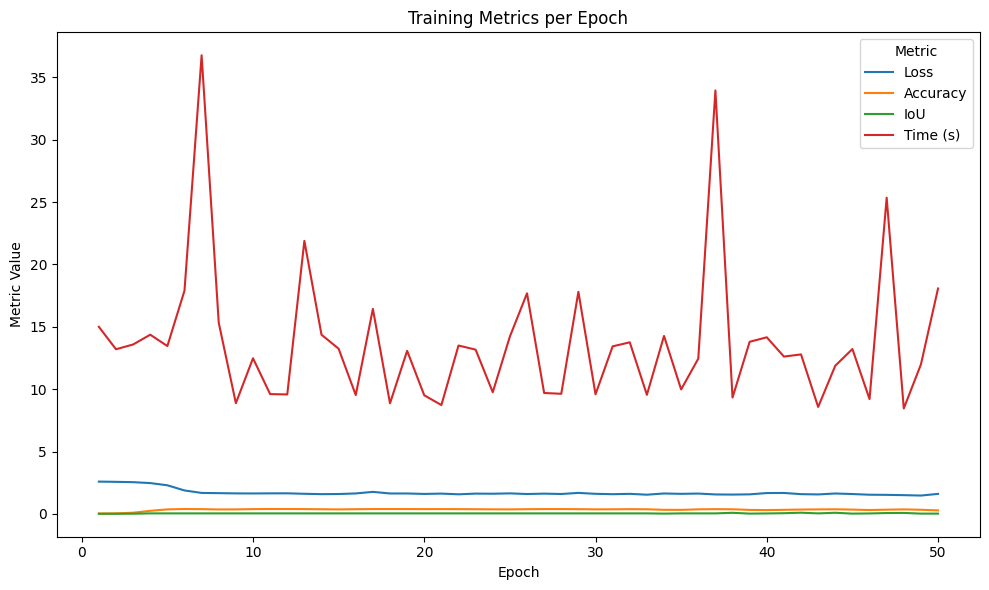

In [31]:
# Visualize with seaborn

# 1) Build DataFrame
df = pd.DataFrame({
    'epoch': range(1, len(loss_history) + 1),
    'Loss': loss_history,
    'Accuracy': acc_history,
    'IoU': iou_history,
    'Time (s)': time_history
})

# 2) Melt to long form for seaborn
df_long = df.melt(id_vars='epoch',
                  var_name='Metric',
                  value_name='Value')

# 3) Plot all metrics in one figure
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='epoch', y='Value', hue='Metric')  
plt.title('Training Metrics per Epoch')  
plt.xlabel('Epoch')  
plt.ylabel('Metric Value')  
plt.legend(title='Metric', loc='best')
plt.tight_layout()
plt.show()

In [32]:
# Export without the index column
df.to_csv("../docs/lora_train_metrics.csv", index=False)

In [16]:
torch.save(lora.lora_state_dict(model), "checkpoints/smartlab_lora_weights_x3_100_20250424.pth")